In [33]:
import numpy as np
import cv2,os
import matplotlib.pyplot as plt

from scipy import interpolate
import torch

### Office Light

In [34]:
office_light = np.array([1.40e-04,4.78e-04,1.45e-03,3.98e-03,4.27e-03,2.58e-03,1.62e-03,1.53e-03,
1.83e-03,2.19e-03,2.43e-03,2.54e-03,2.65e-03,2.71e-03,2.77e-03,2.81e-03,2.82e-03,2.77e-03,0.0026275,
0.00236847,0.00217062, 0.00153536,0.00121575,0.000955384])


In [35]:
# office_light = np.array([4.78e-04,3.98e-03,1.62e-03,1.83e-03,2.43e-03,2.71e-03,2.82e-03,0.0026275,
# 0.00217062,0.00121575,0.000955384])

### Bring Dataset

In [36]:
data_dir = "./crf_datas/20230828/"
cam_H, cam_W = 580, 890
wvls = np.array([420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540,
       550, 560, 570, 580, 590, 600, 610, 620, 640, 650, 660])
size = 100

In [37]:
# wvl images
wvl_imgs = np.zeros(shape=(len(wvls), cam_H, cam_W, 3))

for w in range(len(wvls)):
    wvl_img = cv2.imread(os.path.join(data_dir, '%dnm/capture_0000.png'%wvls[w]))[:,:,::-1]/255.
    wvl_imgs[w] = wvl_img

In [38]:
center_points = np.array([445, 290])

### Visualization

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


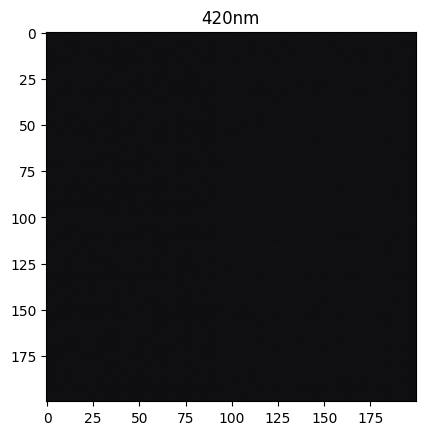

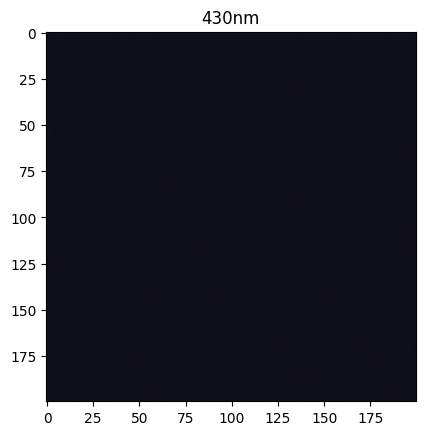

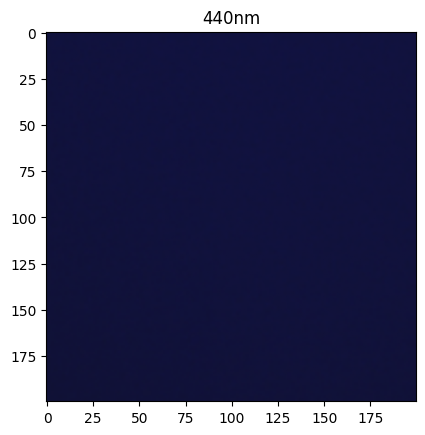

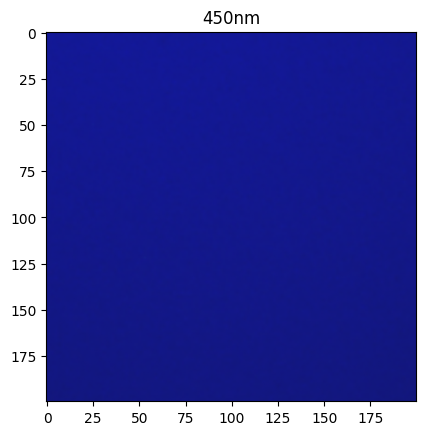

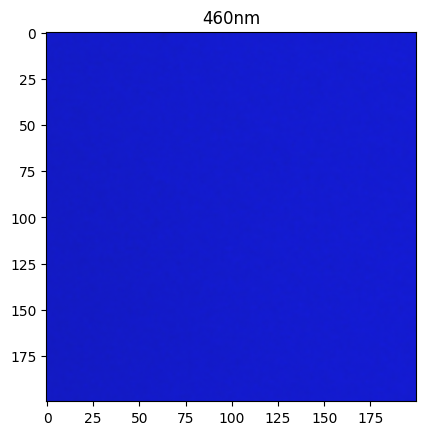

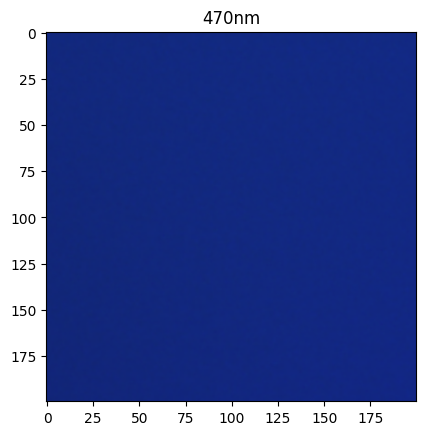

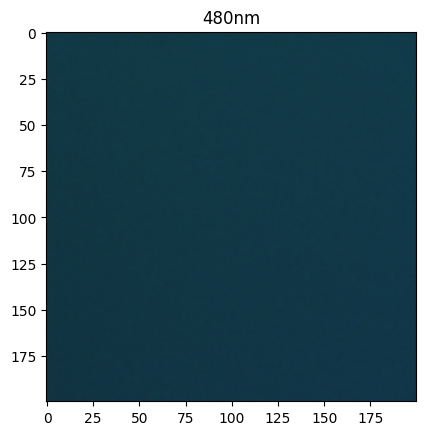

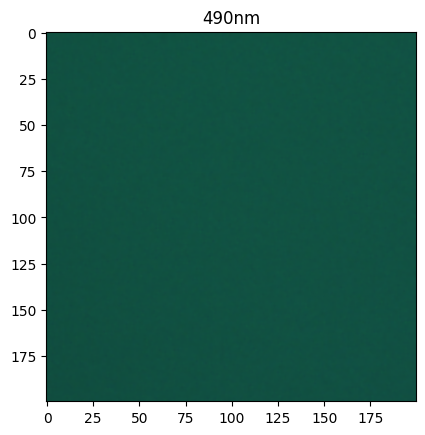

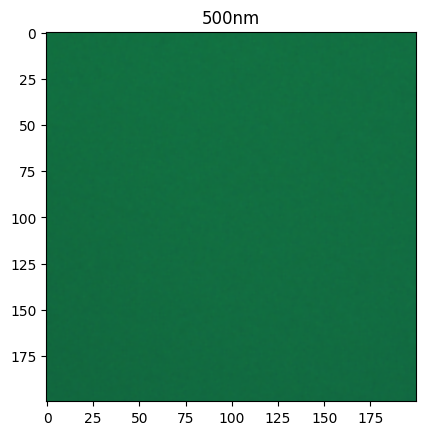

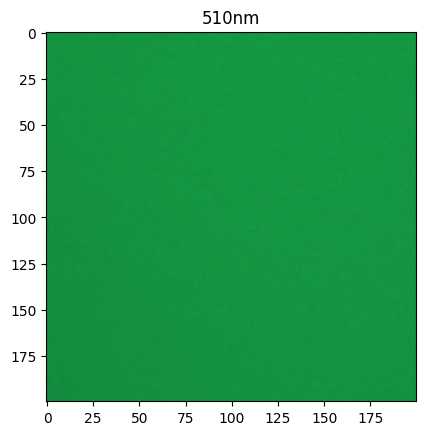

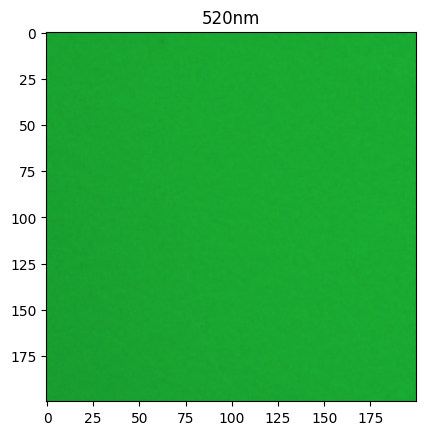

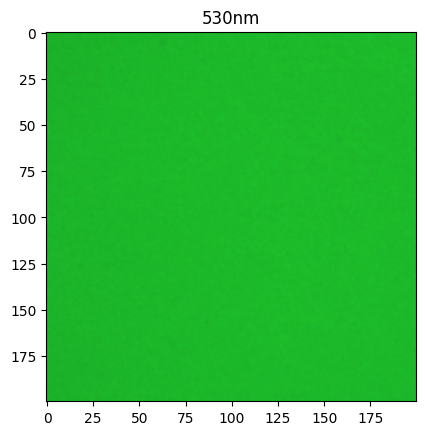

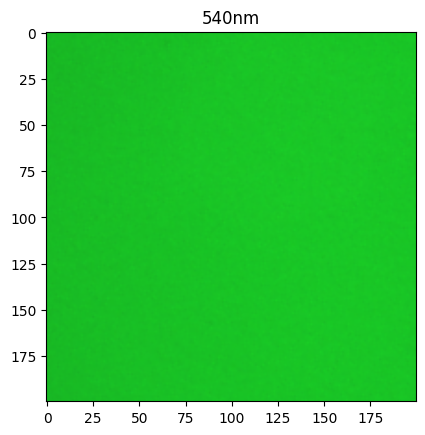

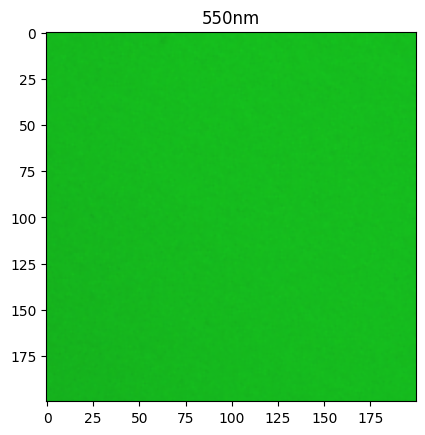

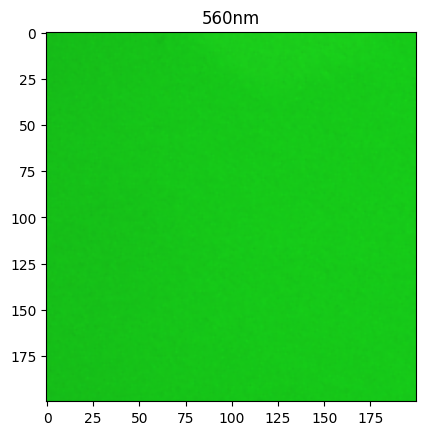

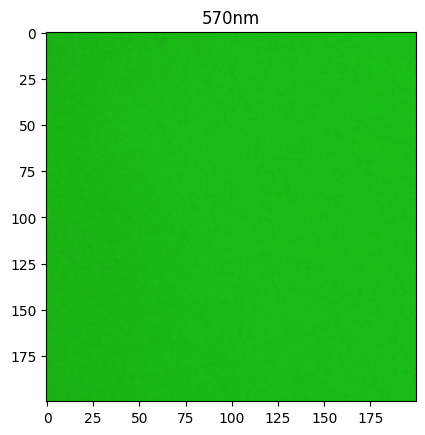

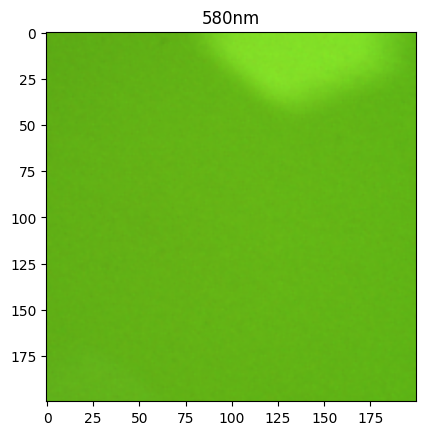

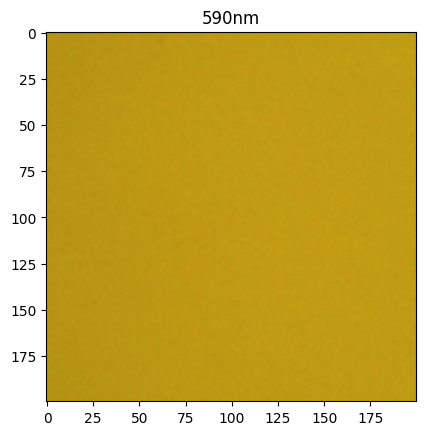

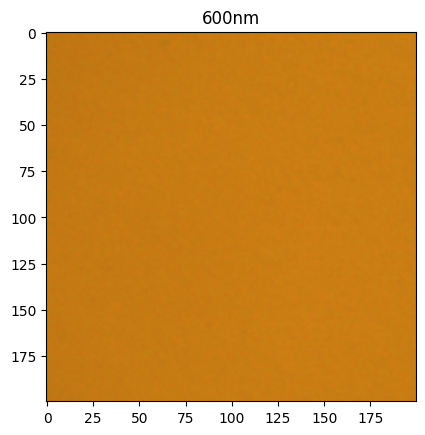

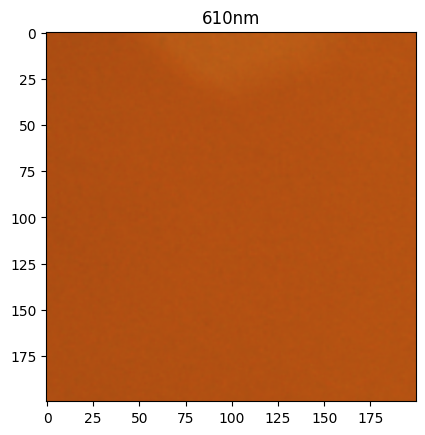

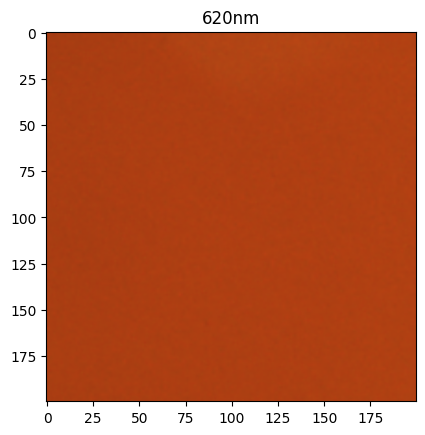

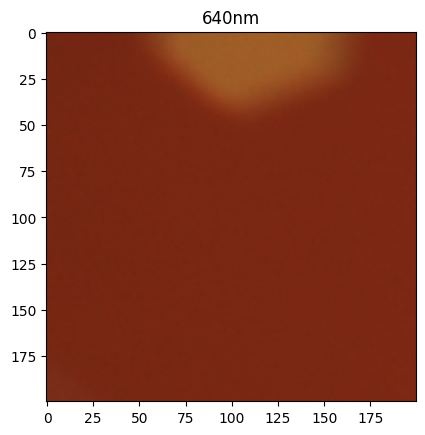

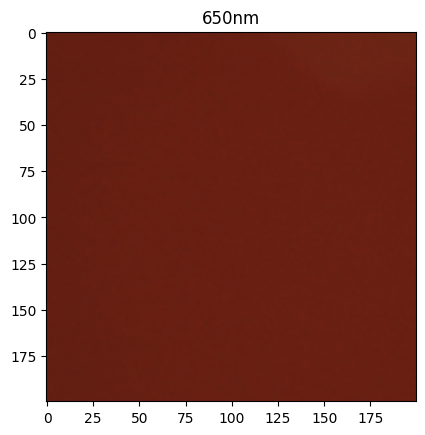

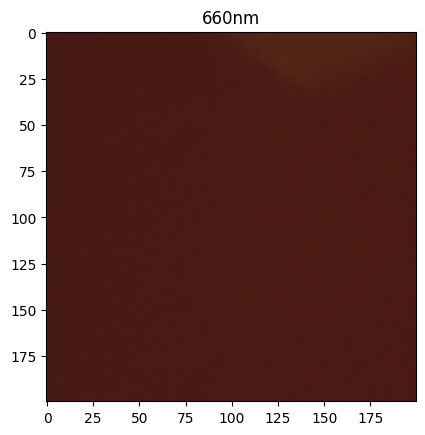

In [39]:
image_intensity = np.zeros(shape = (len(wvls), 3))

for w in range(len(wvls)):
    plt.figure()
    wvl_intensity_zero = wvl_imgs[w, center_points[1]-size:center_points[1]+size, center_points[0]-size : center_points[0]+size].reshape(-1, 3).mean(axis = 0)
    plt.imshow(wvl_imgs[w, center_points[1]-size:center_points[1]+size, center_points[0]-size : center_points[0]+size]), plt.title("%dnm"%wvls[w])

### Image intensity

In [40]:
wvls_intensity = np.zeros(shape = (len(wvls), 3))

for w in range(len(wvls)):
    wvl_intensity = wvl_imgs[w, center_points[1]-size:center_points[1]+size, center_points[0]-size : center_points[0]+size].reshape(-1, 3).mean(axis = 0)

    wvls_intensity[w] = wvl_intensity
    

In [41]:
I_RGB = wvls_intensity * 255.

### CRF interpolation

In [42]:
CRF = np.zeros(shape=(len(wvls), 3))

for c in range(3):
    for w in range(len(wvls)): 
        CRF[w,c] = I_RGB[w,c] / (office_light[w])

### Interpolation

In [43]:
def cubic_interpolation(x_new, x_points, y_points, n):
    tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
    y_new = interpolate.splev(x_new, tck)
    return y_new

In [64]:
# wvls = torch.tensor([430, 450, 480, 500, 520, 550, 580, 600, 620, 650, 660])*1e-9
wvls = torch.tensor([420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540,
       550, 560, 570, 580, 590, 600, 610, 620, 640, 650, 660])*1e-9
new_wvls = torch.linspace(420*1e-9, 660*1e-9, 25) # 400 ~ 660 까지 10nm 간격으로

CRF_R = cubic_interpolation(new_wvls, wvls, CRF[:,0], 4)
CRF_G = cubic_interpolation(new_wvls, wvls, CRF[:,1], 4)
CRF_B = cubic_interpolation(new_wvls, wvls, CRF[:,2], 4)

In [65]:
CRF_Final = np.stack((CRF_R, CRF_G, CRF_B))
CRF_Final[:,0] = CRF_Final[:,1] - 10000

In [66]:
from scipy.interpolate import interp1d
map_scale = interp1d([CRF_Final.min(), CRF_Final.max()], [0.1, 1.])
CRF_Final = torch.tensor(map_scale(CRF_Final).astype(np.float32))

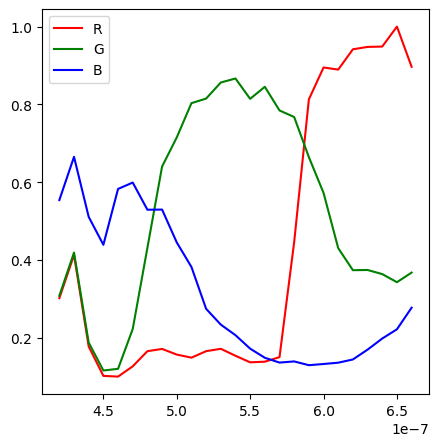

In [67]:
plt.figure(figsize=(5,5))
plt.plot(new_wvls, CRF_Final[0], label = 'R',  c='red')
plt.plot(new_wvls, CRF_Final[1], label = 'G', c='green')
plt.plot(new_wvls, CRF_Final[2], label = 'B', c='blue')
plt.legend()

In [71]:
CRF_Final[:,0], CRF_Final[:,1], CRF_Final[:,2], CRF_Final[:,3]

(tensor([0.3016, 0.3079, 0.5540]),
 tensor([0.4128, 0.4190, 0.6651]),
 tensor([0.1774, 0.1875, 0.5108]),
 tensor([0.1019, 0.1157, 0.4389]))

In [72]:
CRF_Final[:,0] = torch.tensor([0.01, 0.01, 0.02])
CRF_Final[:,1] = torch.tensor([0.01, 0.01, 0.12])
CRF_Final[:,2] = torch.tensor([0.01, 0.02, 0.25]) # 24 : 0.1 50 : 0.25

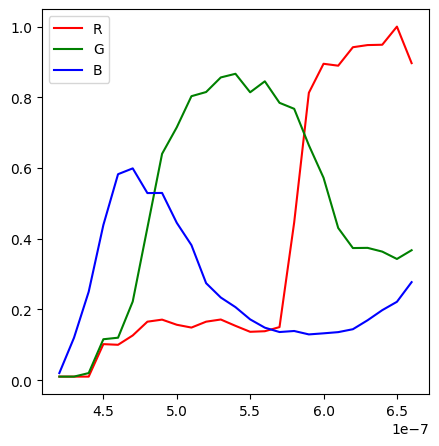

In [73]:
plt.figure(figsize=(5,5))
plt.plot(new_wvls, CRF_Final[0], label = 'R',  c='red')
plt.plot(new_wvls, CRF_Final[1], label = 'G', c='green')
plt.plot(new_wvls, CRF_Final[2], label = 'B', c='blue')
plt.legend()

In [74]:
np.save('CRF.npy', CRF_Final)